The paper "Classifying Unstructured Clinical Notes via Automatic Weak Supervision" tackles the issue of categorizing unstructured clinical notes accurately and efficiently, which can help to enhance the effectiveness of clinical decision-making. Due to the large volume of unstructured clinical data generated, it can be challenging for human experts to categorize and analyze it in a timely manner. To automate this process, machine learning algorithms can be used, but they require a lot of labeled data for training, which can be time-consuming to obtain. The paper proposes a technique for generating weak supervision signals, to train the machine learning model, which can help to overcome this challenge and improve the efficiency and accuracy of clinical note classification. See below the flow diagram of the proposed process:

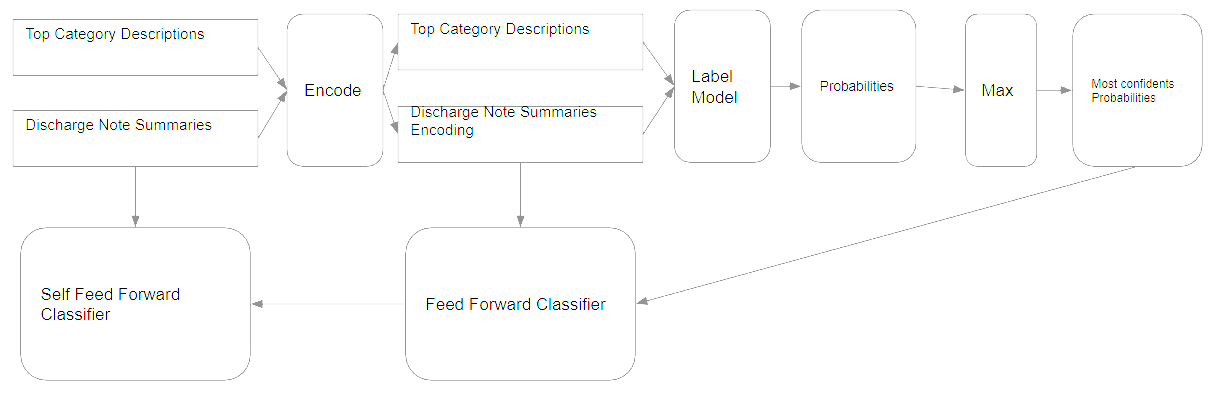

The authors of "Classifying Unstructured Clinical Notes via Automatic Weak Supervision" report that their system, KeyClass, can assign top-level ICD-9 codes to discharge summaries in the MIMIC-III dataset using weak supervision. They achieved high accuracy results on a 19-class classification task, outperforming the baseline system. The accuracy results are listed in the table provided in Section 6.2 of the paper.

The paper compares the performance of KeyClass with two baseline implementations, FastTag weakly supervised and FastTag fully supervised. KeyClass outperforms the weakly supervised FastTag with an F1 score of 0.6252, while underperforming the fully supervised FastTag with an F1 score of 0.67. The goal of the Reproducibility Project  is to achieve similar accuracy results for KeyClass as presented in the table provided in the paper and above.


In [1]:
import utils
import pandas as pd
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joshb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The load_mimic_data function reads in data from several CSV files containing medical data from the MIMIC-III database. The function concatenates data from two files containing ICD-9 codes and drops any rows that contain missing data. It then applies the icd9_to_category function to map the ICD-9 codes to general diagnostic categories. The function reads in a third file containing discharge summary notes and filters out any rows that do not contain discharge summaries. It then joins the resulting dataframes on HADM_ID to obtain a final dataframe.

The resulting dataframe is filtered to include only rows with ICD-9 codes that belong to one of four diagnostic categories. The resulting dataframe is then downsampled to a specific sample size for each category and concatenated into a balanced dataframe. The balanced dataframe is split into a train and test set using train_test_split function, and then the text, ICD-9 codes, and HADM_IDs are saved to separate text files. Finally, the function returns the train and test sets.

In [2]:
train_sentences_dt, test_sentences_dt = utils.load_mimic_data()
train_sentences_dt

,HADM_ID,ICD9_CODE,CATEGORY,TEXT
648563,146103,1,Discharge summary,Admission Date: [**2112-7-18**] ...
395133,199050,1,Discharge summary,Admission Date: [**2122-10-31**] Discha...
543426,120736,0,Discharge summary,Admission Date: [**2139-8-4**] D...
274264,178228,3,Discharge summary,Admission Date: [**2165-2-17**] Discharge...
752859,188352,0,Discharge summary,Admission Date: [**2149-7-25**] ...
...,...,...,...,...
418581,112395,0,Discharge summary,Admission Date: [**2189-6-23**] Dischar...
134696,123494,1,Discharge summary,Admission Date: [**2122-3-15**] ...
343613,138161,2,Discharge summary,Admission Date: [**2107-8-23**] ...
474608,120316,3,Discharge summary,Admission Date: [**2131-8-25**] Discharge...


We ensure that CUDA is available

In [3]:
import torch
print(torch.cuda.is_available())

True


We define a custom encoder class called CustomEncoder. The encoder uses the BlueBert-Base (Uncased) language model trained on PubMed and MIMIC-III.

The CustomEncoder class has two main methods:

encode(sentences, batch_size, show_progress_bar, normalize_embeddings): This method computes sentence embeddings using the forward method. It takes a list of sentences as input, where each sentence can be a string or a list of strings. The batch_size parameter controls the number of sentences that are processed in each batch. The show_progress_bar parameter controls whether a progress bar is displayed during processing. The normalize_embeddings parameter controls whether the embeddings are normalized or not. The method returns a numpy array of embeddings.

forward(sentences, batch_size, show_progress_bar, normalize_embeddings): This method computes sentence embeddings. It takes the same parameters as encode, but it returns a tensor of embeddings instead of a numpy array.

The CustomEncoder class also has three helper methods:

mean_pooling(model_output, attention_mask): This method computes the mean pooling of the token embeddings based on the attention mask. It takes the output of the model and the attention mask as inputs, and returns the mean pooled embeddings.

_text_length(text): This is a helper function that computes the length of the input text. The text can be either a list of ints (which means a single text as input), or a tuple of list of ints (representing several text inputs to the model).

clean_text(sentences): This is a utility function that cleans sentences by lowercasing, removing HTML tags, punctuation, numbers, and non-ASCII characters. It takes a list of sentences as input, where each sentence can be a string or a list of strings. The function returns the cleaned sentences.


In [4]:
from typing import Union
from typing import List
from typing import Optional
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import trange
import torch


class CustomEncoder(torch.nn.Module):

    def __init__(self,
                 pretrained_model_name_or_path:
                 str = 'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12',
                 device: str = "cuda"):
        super(CustomEncoder, self).__init__()
        """Custom encoder class

            This custom encoder class allows KeyClass to use encoders beyond those
            in Sentence Transformers. Here, we will use the BlueBert-Base (Uncased)
            language model trained on PubMed and MIMIC-III [1].

            Parameters
            ----------
            pretrained_model_name_or_path: str
                Is either:
                -- a string with the shortcut name of a pre-trained model configuration to load
                   from cache or download, e.g.: bert-base-uncased.
                -- a string with the identifier name of a pre-trained model configuration that
                   was user-uploaded to our S3, e.g.: dbmdz/bert-base-german-cased.
                -- a path to a directory containing a configuration file saved using the
                   save_pretrained() method, e.g.: ./my_model_directory/.
                -- a path or url to a saved configuration JSON file, e.g.: ./my_model_directory/configuration.json.

            device: str
                Device to use for encoding. 'cpu' by default.

            References
            ----------
            [1] Peng Y, Yan S, Lu Z. Transfer Learning in Biomedical Natural Language Processing:
                An Evaluation of BERT and ELMo on Ten Benchmarking Datasets. In Proceedings of the
                Workshop on Biomedical Natural Language Processing (BioNLP). 2019.
        """
        super(CustomEncoder, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(
            pretrained_model_name_or_path)
        self.model = AutoModel.from_pretrained(pretrained_model_name_or_path)
        self.model.train()
        # The model is set in evaluation mode by default using model.eval()
        # (Dropout modules are deactivated) To train the model, you should
        # first set it back in training mode with model.train()

        self.device = device

        self.to(device)

    def encode(self,
               sentences: Union[str, List[str]],
               batch_size: int = 32,
               show_progress_bar: Optional[bool] = False,
               normalize_embeddings: bool = False):
        """
        Computes sentence embeddings using the forward function

        Parameters
        ----------
        text: the text to embed
        batch_size: the batch size used for the computation
        """
        self.model.eval()  # Set model in evaluation mode.
        with torch.no_grad():
            embeddings = self.forward(sentences,
                                      batch_size=batch_size,
                                      show_progress_bar=show_progress_bar,
                                      normalize_embeddings=normalize_embeddings
                                      ).detach().cpu().numpy()
        self.model.train()
        return embeddings
    def forward(self,
            sentences: Union[str, List[str]],
            batch_size: int = 32,
            show_progress_bar: Optional[bool] = None,
            normalize_embeddings: bool = False):
        """
        Computes sentence embeddings

        Parameters
        ----------
        sentences: the sentences to embed
        batch_size: the batch size used for the computation
        show_progress_bar: This option is not used, and primarily present due to compatibility.
        normalize_embeddings: This option is not used, and primarily present due to compatibility.
        """

        all_embeddings = []

        # Sort sentences by length
        length_sorted_idx = np.argsort([-utils._text_length(sen) for sen in sentences])
        sentences_sorted = [sentences[idx] for idx in length_sorted_idx]

        # Process sentences in batches
        for start_index in trange(0, len(sentences), batch_size, desc="Batches", disable=not show_progress_bar):
            sentences_batch = sentences_sorted[start_index:start_index + batch_size]
            features = self.tokenizer(sentences_batch, return_tensors='pt', truncation=True, max_length=512, padding=True)
            features = features.to(self.device)
            out_features = self.model.forward(**features)
            embeddings = utils.mean_pooling(out_features, features['attention_mask'])

            if normalize_embeddings:
                embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

            all_embeddings.extend(embeddings)

        # Reorder embeddings to match the original order of sentences
        all_embeddings = [all_embeddings[idx] for idx in np.argsort(length_sorted_idx)]
        all_embeddings = torch.stack(all_embeddings)  # Converts to tensor

        return all_embeddings

We define a pre-trained encoder "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12" and initialize a model instance of the "CustomEncoder" class using this pre-trained encoder.
It defines the batch size, whether or not to show progress bars and whether to normalize embeddings.
It prepares training and test notes text data by concatenating and cleaning text data.
It generates embeddings for the cleaned training and test notes text data using the initialized model instance, by calling the model.encode() method. These embeddings are generated in batches of size batch_size and progress bar is shown during encoding. If the normalize_embeddings parameter is set to True, the embeddings are normalized, otherwise they are not normalized.

In [5]:
base_encoder = "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12"

model = CustomEncoder(pretrained_model_name_or_path=base_encoder,device='cuda')

batch_size = 128
show_progress_bar = True
normalize_embeddings = False

train_notes_text = [string for line in train_sentences_dt['TEXT'] for string in utils.clean_text(line)]
test_notes_text = [string for line in test_sentences_dt['TEXT'] for string in utils.clean_text(line)]

train_notes_embeddings = model.encode(
            sentences=train_notes_text,
            batch_size=batch_size,
            show_progress_bar=show_progress_bar,
            normalize_embeddings=normalize_embeddings)

test_notes_embeddings = model.encode(
            sentences=test_notes_text,
            batch_size=batch_size,
            show_progress_bar=show_progress_bar,
            normalize_embeddings=normalize_embeddings)

Some weights of the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Batches: 100%|██████████████████████████████████████████████████████████████████████████

Next we define several functions for creating and training weak supervision label models.

The get_vocabulary function takes a text corpus and creates a word indicator matrix and a vocabulary. The word indicator matrix is an n x m matrix, where n is the number of documents and m is the number of words in the vocabulary, and each entry indicates the presence or absence of a word in a document.

The assign_categories_to_keywords function assigns categories to keywords based on their embeddings and creates a mask that indicates which words belong to which categories.

The create_label_matrix function takes the word indicator matrix, the keywords, and the assigned categories and creates a label matrix of votes of each labeling function on all data points.

The LabelModelWrapper class is an abstraction for training weak supervision label models.  The class takes in the label matrix of votes of each labeling function on all data points, the gold training/development set labels, the number of classes, the device (CPU or GPU), and the name of the label model to be used. The class provides methods to display summary statistics for the labeling functions, train the label model, predict probabilistic labels, and predict labels using the trained label model with ties broken according to a policy.

The CreateLabellingFunctions class is a wrapper for several functions that are used to create and train weak supervision label models. It takes in the name of the base encoder, the device (CPU or GPU), and the name of the label model to be used. It provides a method get_labels that takes a text corpus, label names, minimum document frequency, n-gram range, top k, the gold training/development set labels, the learning rate, the number of epochs to train, a flag to indicate whether to display verbose output, and the number of classes. The method returns probabilistic labels predicted by the label model.

In [6]:
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling import LFAnalysis
import nltk
from sentence_transformers import SentenceTransformer
import sentence_transformers
from sklearn.feature_extraction.text import CountVectorizer
from nltk import download, pos_tag, corpus
from scipy.spatial import distance
from snorkel.labeling.model.label_model import LabelModel


class LabelModelWrapper:
    """Class to train any weak supervision label model.
        This class is an abstraction to the label models. We can
        ideally use any label model, but currently we only support
        data programing. Future plan is to include Dawid-Skeene.
        Parameters
        ----------
        y_train: np.array
            Gold training/development set labels
        n_classes: int
            Number of classes/categories. Default 2.
        label_matrix: pd.DataFrame or np.array
            Label matrix of votes of each LF on all data points
    """

    def __init__(self,
                 label_matrix,
                 y_train=None,
                 n_classes=2,
                 device='cuda',
                 model_name='data_programming'):
        if not isinstance(label_matrix, pd.DataFrame):
            raise ValueError(f'label_matrix must be a DataFrame.')

        _VALID_LABEL_MODELS = ['data_programming', 'majority_vote']
        if model_name not in _VALID_LABEL_MODELS:
            raise ValueError(
                f'model_name must be one of {_VALID_LABEL_MODELS} but passed {model_name}.'
            )

        self.label_matrix = label_matrix.to_numpy()
        self.y_train = y_train
        self.n_classes = n_classes
        self.LF_names = list(label_matrix.columns)
        self.learned_weights = None  # learned weights of the labeling functions
        self.trained = False  # The label model is not trained yet
        self.device = device
        self.model_name = model_name

    def display_LF_summary_stats(self):
        """Displays summary statistics for LFs
        """
        df_LFAnalysis = LFAnalysis(L=self.label_matrix).lf_summary(
            Y=self.y_train, est_weights=self.learned_weights)
        df_LFAnalysis.index = self.LF_names

        return df_LFAnalysis

    def train_label_model(self,
                          n_epochs=500,
                          class_balance=None,
                          log_freq=100,
                          lr=0.01,
                          seed=13,
                          cuda=False):
        """Train the label model
            Parameters
            ----------
            n_epochs: int
                The number of epochs to train (where each epoch is a single
                optimization step), default is 100

            class_balance: list
                Each class’s percentage of the population, by default None
            log_freq: int
                Report loss every this many epochs (steps), default is 10
            lr: float
                Base learning rate (will also be affected by lr_scheduler choice
                and settings), default is 0.01
            seed: int
                A random seed to initialize the random number generator with
        """
        print(f'==== Training the label model ====')
        if self.model_name == 'data_programming':
            self.label_model = LabelModel(cardinality=self.n_classes,
                                          device=self.device)
            if cuda == True:
                self.label_model = self.label_model.cuda()
            self.label_model.fit(self.label_matrix,
                                 n_epochs=n_epochs,
                                 class_balance=class_balance,
                                 log_freq=log_freq,
                                 lr=lr,
                                 seed=seed,
                                 optimizer='sgd')
            self.trained = True
            self.learned_weights = self.label_model.get_weights()
        elif self.model_name == 'majority_vote':
            self.label_model = MajorityLabelVoter(cardinality=self.n_classes)
            self.trained = True

    def predict_proba(self):
        """Predict probabilistic labels P(Y | lambda)
        """
        if not self.trained:
            print(
                "Model must be trained before predicting probabilistic labels")
            return

        y_proba = pd.DataFrame(
            self.label_model.predict_proba(L=self.label_matrix),
            columns=[f'Class {i}' for i in range(self.n_classes)])
        return y_proba

    def predict(self, tie_break_policy='random'):
        """Predict labels using the trained label model with ties broken according to policy.

            Parameters
            ----------
            tie_break_policy: str
                Policy to break ties when converting probabilistic labels to predictions.
                Refer snorkel package for more details.
        """
        if not self.trained:
            print("Model must be trained before predicting labels")
            return 0

        y_pred = self.label_model.predict(L=self.label_matrix,
                                          tie_break_policy=tie_break_policy)
        return y_pred


class CreateLabellingFunctions:
    """Class to create and store labelling functions.
    """

    def __init__(self,
                 base_encoder='paraphrase-mpnet-base-v2',
                 device: torch.device = torch.device("cuda"),
                 label_model: str = 'data_programming'):

        self.device = device
        #self.encoder = Encoder(model_name=base_encoder, device=device)
        self.encoder = CustomEncoder(pretrained_model_name_or_path=base_encoder, device='cuda')

        self.label_matrix = None
        self.keywords = None
        self.word_indicator_matrix = None
        self.vocabulary = None
        self.vocabulary_embeddings = None
        self.assigned_category = None
        self.label_model_name = label_model

    def get_labels(self,
                   text_corpus,
                   label_names,
                   min_df,
                   ngram_range,
                   topk,
                   y_train,
                   label_model_lr,
                   label_model_n_epochs,
                   verbose=True,
                   n_classes=2):
        ## main driver function

        ## get the bert embeddings of the categories
        self.label_embeddings = self.encoder.encode(sentences=label_names)

        ## get vocab according to n-grams
        self.word_indicator_matrix, self.vocabulary = utils.get_vocabulary(\
            text_corpus=text_corpus,
            max_df=1.0,
            min_df=min_df,
            ngram_range=ngram_range)

        # embed vocab to compare with label_embeddings
        self.vocabulary_embeddings = self.encoder.encode(
            sentences=self.vocabulary)

        # labeler.assign_categories_to_keywords(cutoff=0.9)
        self.keywords, self.assigned_category, self.word_indicator_matrix = utils.assign_categories_to_keywords(\
            vocabulary=self.vocabulary,
            vocabulary_embeddings=self.vocabulary_embeddings,
            label_embeddings=self.label_embeddings,
            word_indicator_matrix=self.word_indicator_matrix,
            topk=topk)

        if verbose:
            print('labeler.vocabulary:\n', len(self.vocabulary))
            print('labeler.word_indicator_matrix.shape',
                  self.word_indicator_matrix.shape)

            print('Len keywords', len(self.keywords))
            print('assigned_category: Unique and Counts',
                  np.unique(self.assigned_category, return_counts=True))
            for u in range(len(label_names)):
                inds = np.where(self.assigned_category == u)[0]
                print(label_names[u], self.keywords[inds])

        self.label_matrix = utils.create_label_matrix(\
            word_indicator_matrix=self.word_indicator_matrix,
            keywords=self.keywords,
            assigned_category=self.assigned_category)

        #     print('labeler.label_matrix', np.unique(labeler.label_matrix, return_counts=True))
        label_model = LabelModelWrapper(\
            label_matrix=self.label_matrix,
            n_classes=n_classes,
            y_train=y_train,
            device=self.device,
            model_name=self.label_model_name)

        label_model.train_label_model(\
            lr=label_model_lr,
            n_epochs=label_model_n_epochs,
            cuda=True if torch.cuda.is_available() else False)

        proba_preds = label_model.predict_proba().values

        label_model.display_LF_summary_stats()
        return proba_preds


\
Next we define:
y_test - a NumPy array containing the ICD9 codes for the test set of clinical notes.
y_train - a NumPy array containing the ICD9 codes for the training set of clinical notes.
label_names a list of strings containing the names of the labels for the different classes.
labeler - This is a labelling function object, which is used to train the machine learning model.
min_df = 0.001: The minimum document frequency for the count vectorizer.
ngram_range = (1, 3): Range of n-grams to be considered by the count vectorizer.
topk = 600: Maximum number of features to be considered by the count vectorizer.
label_model_lr = 0.01: The learning rate for the label model.
label_model_n_epochs = 100: The number of epochs to be used for training the label model.
n_classes = 4: The number of classes in the dataset.
By calling labeler.get_labels(...), we train the machine learning model using the training data and the parameters set above. The resulting model is used to predict the probabilities of each label for the test set of clinical notes. The probabilities are stored in the proba_preds variable.

In [7]:
y_test = np.array(test_sentences_dt['ICD9_CODE'].tolist())
y_train  = np.array(train_sentences_dt['ICD9_CODE'].tolist())

print('Class distribution', np.unique(y_train, return_counts=True))

label_names = ["Acute meningitis, Amebiasis, Botulism, Chickenpox, Cholera, Cryptosporidiosis,Dengue fever, Diphtheria, Ebola virus disease, Enterobiasis, Giardiasis, Gonococcal,infection, Hansen's disease, Hepatitis A, Hepatitis B, HIV/AIDS, Infectious mononucleosis,  Influenza, Legionellosis, Leprosy, Lyme disease, Malaria, Measles, Mumps, Necrotizing  fasciitis, Pelvic inflammatory disease, Pertussis, Plague, Pneumococcal infection,  Poliomyelitis, Rabies, Rubella, Salmonella infection, Sepsis, Shigellosis, Syphilis,  Tetanus, Tuberculosis, Typhoid fever, Varicella",
               "Malignant neoplasms, Benign neoplasms, Skin neoplasms, Breast neoplasms,  Prostate neoplasms, Lung neoplasms, Colon neoplasms, Ovarian neoplasms, Pancreatic  neoplasms, Renal neoplasms, Bladder neoplasms, Liver neoplasms, Brain neoplasms,  Thyroid neoplasms, Lymphoma, Leukemia, Melanoma, Esophageal neoplasms, Gastric neoplasms,  Endocrine neoplasms, Oral neoplasms, Rectal neoplasms, Testicular neoplasms, Uterine  neoplasms, Vulvar neoplasms, Cervical neoplasms, Hodgkin's disease, Non-Hodgkin's  lymphoma, Bone neoplasms, Soft tissue neoplasms, Mesothelioma, Adrenal gland neoplasms,  Kaposi's sarcoma, Multiple myeloma, Cholangiocarcinoma, Carcinoid tumor, Gastrointestinal stromal tumor, Head and neck neoplasms, Parathyroid neoplasms",
               "Disorders of thyroid gland, Diabetes mellitus, Disorders of adrenal gland,  Obesity, Hypoglycemia, Disorders of parathyroid gland, Disorders of pituitary gland,  Nutritional deficiencies, Disorders of lipid metabolism, Disorders of mineral metabolism,  Hypercalcemia, Hyperglycemia, Malnutrition, Lipidoses, Disorders of carbohydrate  metabolism, Disorders of calcium metabolism, Hypocalcemia, Disorders of iron metabolism,  Disorders of magnesium metabolism, Disorders of potassium metabolism, Metabolic  acidosis, Metabolic alkalosis, Disorders of water metabolism, Hyperkalemia, Hyperlipidemia,  Hypomagnesemia, Hypoparathyroidism, Hyperparathyroidism, Anemia of chronic disease,  Disorders of copper metabolism, Disorders of phosphorus metabolism, Disorders of  zinc metabolism, Disorders of water-electrolyte balance, Disorders of glycogen metabolism,  Hyperaldosteronism, Hypermagnesemia, Hypokalemia, Hypophosphatemia, Malabsorption  syndromes, Metabolic encephalopathy, Gout, and Acid-base disorders",
               "Hematological malignancies, Hemolytic anemia, Thalassemia, Hemophilia, Leukemia,Hemorrhagic disorders, Lymphoma, Myeloproliferative disorders, Myelodysplastic syndromes,  Aplastic anemia, Sickle cell anemia, Multiple myeloma, Coagulopathy, Polycythemia,  Idiopathic thrombocytopenic purpura, Hemangioma, Hemangioblastoma, Hematoma, Hematopoietic  stem cell transplant, Hemoglobinopathy, Hemopericardium, Hemoperitoneum, Hemophilia  A, Hemophilia B, Hemophagocytic lymphohistiocytosis, Hemoptysis, Hemorrhagic stroke,  Hemostasis, Hematuria, Hemochromatosis, Hemodialysis, Hemodynamic instability, Hemolytic     uremic syndrome, Hemophiliac arthropathy, Hemorrhoidectomy, Hemostatic agents, Hemostatic  disorders"]

label_model = 'data_programming'
base_encoder = 'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12'

labeler = CreateLabellingFunctions(
        base_encoder=base_encoder,
        device='cuda',
        label_model=label_model)
min_df = 0.001
ngram_range = (1, 3)
topk = 600
label_model_lr = 0.01
label_model_n_epochs = 100
n_classes = 4

proba_preds = labeler.get_labels(
        text_corpus=train_notes_text,
        label_names=label_names,
        min_df=min_df,
        ngram_range=ngram_range,
        topk=topk,
        y_train=y_train,
        label_model_lr=label_model_lr,
        label_model_n_epochs=label_model_n_epochs,
        verbose=True,
        n_classes=n_classes)



Class distribution (array([0, 1, 2, 3]), array([63, 75, 70, 72], dtype=int64))


Some weights of the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


labeler.vocabulary:
 380780
labeler.word_indicator_matrix.shape (280, 2400)
Len keywords 2400
assigned_category: Unique and Counts (array([0, 1, 2, 3], dtype=int64), array([600, 600, 600, 600], dtype=int64))
Acute meningitis, Amebiasis, Botulism, Chickenpox, Cholera, Cryptosporidiosis,Dengue fever, Diphtheria, Ebola virus disease, Enterobiasis, Giardiasis, Gonococcal,infection, Hansen's disease, Hepatitis A, Hepatitis B, HIV/AIDS, Infectious mononucleosis,  Influenza, Legionellosis, Leprosy, Lyme disease, Malaria, Measles, Mumps, Necrotizing  fasciitis, Pelvic inflammatory disease, Pertussis, Plague, Pneumococcal infection,  Poliomyelitis, Rabies, Rubella, Salmonella infection, Sepsis, Shigellosis, Syphilis,  Tetanus, Tuberculosis, Typhoid fever, Varicella ['abcesspostoperative septic shockvasopressorsresolvedpostop'
 'aboveconcerning fordiscitisostemyelitis' 'abpositive blood chsv'
 'abscess chronic sigmoiddiverticular' 'abscessautoimmune'
 'abscessautoimmune cirrhosisceliac' 'abscess

C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-m

C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-m

C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-m

C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-m

C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1  0  1  2  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\envs\KeyClass-m

Next we compute the accuracy of the probabalistic labeling

In [8]:
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score
import joblib


y_train_pred = np.argmax(proba_preds, axis=1)
print('Label Model Predictions: Unique value and counts',np.unique(y_train_pred, return_counts=True))
print('Label Model Training Accuracy', np.mean(y_train_pred == y_train))

average = 'weighted'
training_metrics_with_gt = utils.compute_metrics(y_preds=y_train_pred, y_true=y_train, average=average)

utils.print_pretty("Label Accuracy:",training_metrics_with_gt)


Label Model Predictions: Unique value and counts (array([0, 1, 2, 3], dtype=int64), array([80, 67, 81, 52], dtype=int64))
Label Model Training Accuracy 0.33214285714285713
Label Accuracy::
 Accuracy  Precision   Recall
 0.334186   0.343197 0.332143


Next we define our classifier  FeedForwardFlexible that implements a feedforward neural network. The network takes as input a tensor x and passes it through a base encoder (encoder_model) before passing it through a series of linear layers with non-linear activation functions and dropout layers. The final output is either the softmax or log-softmax of the output of the last linear layer depending on the mode parameter passed to the forward method.

The FeedForwardFlexible class also has two methods for making predictions: predict and predict_proba. predict takes as input a tensor x_test and returns the class predictions (i.e., the class with the highest predicted probability) for each example in x_test. predict_proba returns the predicted probabilities for each class for each example in x_test. Both methods use the forward method to obtain the predicted probabilities.

The FeedForwardFlexible class can be instantiated with a base encoder, a list of hidden layer sizes, an activation function, and a device to use for training.

In [9]:
from typing import Iterable
class FeedForwardFlexible(torch.nn.Module):

    def __init__(self,
                 encoder_model: torch.nn.Module,
                 h_sizes: Iterable[int] = [768, 256, 64, 2],
                 activation: torch.nn.Module = torch.nn.LeakyReLU(),
                 device: str = "cuda"):
        super(FeedForwardFlexible, self).__init__()
        """
        Flexible feed forward network over a base encoder.


        Parameters
        ----------
        encoder_model: The base encoder model
        h_sizes: Linear layer sizes to be used in the MLP
        activation: Activation function to be use in the MLP.
        device: Device to use for training. 'cpu' by default.
        """

        self.encoder_model = encoder_model
        self.device = device
        self.layers = torch.nn.ModuleList()
        for k in range(len(h_sizes) - 1):
            self.layers.append(torch.nn.Linear(h_sizes[k], h_sizes[k + 1]))
            self.layers.append(activation)
            self.layers.append(torch.nn.Dropout(p=0.5))

        self.to(device)

    def forward(self, x, mode='inference', raw_text=True):
        if raw_text:
            x = self.encoder_model.forward(x)

        for layer in self.layers:
            x = layer(x)

        if mode == 'inference':
            x = torch.nn.Softmax(dim=-1)(x)
        elif mode == 'self_train':
            x = torch.nn.LogSoftmax(dim=-1)(x)

        return x

    def predict(self, x_test, batch_size=128, raw_text=True):
        preds = self.predict_proba(x_test,
                                   batch_size=batch_size,
                                   raw_text=raw_text)
        preds = np.argmax(preds, axis=1)
        return preds

    def predict_proba(self, x_test: List[str], batch_size: int = 128, raw_text: bool = True) -> np.array:
        """
        Predict probabilities for given test data

        Parameters
        ----------
        x_test: List of test data
        batch_size: Batch size for processing
        raw_text: If True, assumes x_test contains raw text. If False, assumes x_test contains pre-processed data
        """
        with torch.no_grad():
            self.eval()
            probs_list = []
            N = len(x_test)
            for i in range(0, N, batch_size):
                test_batch = x_test[i:i + batch_size]
                if not raw_text:
                    test_batch = test_batch.to(self.device)

                probs = self.forward(test_batch,
                                     mode='inference',
                                     raw_text=raw_text).cpu().numpy()
                probs_list.append(probs)

            self.train()
        return np.concatenate(probs_list, axis=0)

Next we define a  train() function which trains a classifier. The function takes as input the model to train, the training data features (X_train) and ground truth (y_train), device to use for training (default is GPU), sample weights array for each sample (default is None), number of epochs to train the model, batch size, loss function, flag for raw text, learning rate, weight decay parameter, and early stopping patience.

The function starts by converting the training data features and ground truth to PyTorch tensors if they are not already. It then defines the Adam optimizer and ExponentialLR scheduler. The model is then set to train mode and the function starts training the model for the specified number of epochs.

During each epoch, the function randomly shuffles the training data and processes the data in batches. It computes the loss and backpropagates the error through the model. The loss is also multiplied by sample weights (if provided) and averaged. The function then clips the gradients, updates the parameters, and computes the running loss.

The function also tracks the best loss, and if the running loss does not improve for a specified number of epochs, the function terminates training (early stopping). The function returns the trained model with the best loss.

In [10]:
import torch
import numpy as np
from typing import List, Union, Optional, Callable
from copy import deepcopy
from tqdm import trange

def to_tensor(data: Union[np.ndarray, torch.Tensor]) -> torch.Tensor:
    if isinstance(data, np.ndarray):
        return torch.from_numpy(data)
    else:
        return data

def to_device(data: torch.Tensor, device: torch.device) -> torch.Tensor:
    return data.to(device)

def prepare_inputs_and_model(X_train, y_train, sample_weights, model, device):
    X_train = to_tensor(X_train)
    y_train = to_tensor(y_train)
    sample_weights = to_tensor(sample_weights) if sample_weights is not None else None
    model.to(device)
    return X_train, y_train, sample_weights

def setup_optimizer_and_scheduler(model, lr, weight_decay):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    return optimizer, scheduler

def early_stopping(running_loss, best_loss, tolcount, patience, model):
    if running_loss <= best_loss:
        best_loss = running_loss
        tolcount = 0
        best_state_dict = deepcopy(model.state_dict())
    else:
        tolcount += 1

    if tolcount > patience:
        model.load_state_dict(best_state_dict)
        return model, True

    return model, False

def calculate_loss(model: torch.nn.Module,
                   batch_x: torch.Tensor,
                   batch_y: torch.Tensor,
                   criterion: Callable,
                   sample_weights: Optional[torch.Tensor],indices) -> torch.Tensor:
    batch_y = to_device(batch_y, model.device)
    batch_x = to_device(batch_x, model.device)

    out = model.forward(batch_x, mode='inference', raw_text=False)
    loss = criterion(out, batch_y)

    if sample_weights is not None:
        batch_weight = sample_weights[indices]
        batch_weight = to_device(batch_weight, model.device)
        loss = torch.mul(loss, batch_weight).mean()
    else:
        loss = loss.mean()

    return loss


def process_batch(optimizer, model, X_batch, y_batch, criterion, sample_weights, device,indices):
    optimizer.zero_grad()
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    loss = calculate_loss(model, X_batch, y_batch, criterion, sample_weights,indices)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    return loss.item()


def train_epoch(model, X_train, y_train, optimizer, criterion, sample_weights, device, batch_size):
    N = len(X_train)
    permutation = torch.randperm(N)
    running_loss = 0
    for i in range(0, N, batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]
        loss = process_batch(optimizer, model, batch_x, batch_y, criterion, sample_weights, device,indices)
        running_loss += (loss * len(batch_x) / N)
    return running_loss

def train(model: torch.nn.Module,
          X_train: Union[List[str], np.ndarray],
          y_train: Union[np.ndarray, torch.Tensor],
          device: torch.device = torch.device("cuda"),
          sample_weights: Optional[np.ndarray] = None,
          epochs: int = 200,
          batch_size: int = 128,
          criterion: Callable = torch.nn.CrossEntropyLoss(reduction='none'),
          raw_text: bool = False,
          lr: float = 1e-3,
          weight_decay: float = 1e-4,
          patience: int = 2) -> torch.nn.Module:
    
    X_train, y_train, sample_weights = prepare_inputs_and_model(X_train, y_train, sample_weights, model, device)
    optimizer, scheduler = setup_optimizer_and_scheduler(model, lr, weight_decay)

    model = model.train()
    best_loss = np.inf
    tolcount = 0
    best_state_dict = None

    for _ in trange(epochs, unit="batch"):
        running_loss = train_epoch(model, X_train, y_train, optimizer, criterion, sample_weights, device, batch_size)
        scheduler.step()
        model, stop = early_stopping(running_loss, best_loss, tolcount, patience, model)
        if stop:
            return model

    return model

Here we call the load_data function and instantiate CustomEncoder

In [11]:
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
max_num=500

X_train_embed_masked, y_train_lm_masked, y_train_masked,X_test_embed, y_test,sample_weights_masked, proba_preds_masked = utils.load_data(proba_preds,max_num,train_notes_embeddings,test_notes_embeddings,y_train,y_test)

base_encoder = 'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12'
encoder = CustomEncoder(pretrained_model_name_or_path=base_encoder, device='cuda')

Confidence of least confident data point of class 0: 0.11135282436704406
Confidence of least confident data point of class 1: 0.11957945008889953
Confidence of least confident data point of class 2: 0.1410311369257383
Confidence of least confident data point of class 3: 0.11500740565055324

==== Data statistics ====
Size of training data: (280, 768), testing data: (120, 768)
Size of testing labels: (120,)
Size of training labels: (280,)
Training class distribution (ground truth): [0.225      0.26785714 0.25       0.25714286]
Training class distribution (label model predictions): [0.28571429 0.23928571 0.28928571 0.18571429]

KeyClass only trains on the most confidently labeled data points! Applying mask...

==== Data statistics (after applying mask) ====
Training class distribution (ground truth): [0.225      0.26785714 0.25       0.25714286]
Training class distribution (label model predictions): [0.28571429 0.23928571 0.28928571 0.18571429]


Some weights of the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Here we instantiate our classifier

In [12]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
h_sizes = [768, 256, 64, 4]
activation = 'torch.nn.LeakyReLU()'

classifier = FeedForwardFlexible(
        encoder_model=encoder,
        h_sizes=h_sizes,
        activation=eval(activation),
        device=torch.device('cuda'))


This is a utility function to print accuracy metrics

The below code defines two functions, get_q_soft and self_train, that can be used for model refinement via self-training.

The get_q_soft function takes in the current predictions p of the model and computes a target distribution q using soft labeling as described in Xie et al., 2016. Specifically, q is computed by squaring and normalizing p.

The self_train function performs the self-training process for a given classifier. It takes in the following arguments:

model: the ML/DL model to self-train on
X_train: feature vectors for training dataset
X_val: feature vectors for validation
y_val: ground truths for validation
device: device to use for self-training, defaults to "cuda"
lr: learning rate for self-training
weight_decay: weight decay parameter for regularization/to prevent overfitting
batch_size: number of samples to feed into the model before updating hyperparameters for self-training
q_update_interval: number of steps before q is updated for self-training
patience: number of consecutive epochs of no performance improvement before terminating training (for early stopping) for self-training
self_train_thresh: if p matches q at a rate above this threshold for "patience" number of epochs, then self-training will stop early (if predictions p are not flipping, stop early)
print_eval: boolean that prints validation metrics if True, and does not if False
The function first sets up the model, criterion, and optimizer. It then updates p every batch and q every epoch. For each epoch, it computes p for a random batch of samples using the current model, and then uses get_q_soft to compute the corresponding q. It then updates the model using q as the target distribution for the criterion loss. The function stops early if p matches q at a rate above self_train_thresh for patience number of epochs. If print_eval is True, the function also prints out validation metrics. Finally, the function returns the trained model.

In [13]:
def get_q_soft(p: np.ndarray):
    """Get target distribution for model refinement via self-training.

    Soft labeling (Xie et al., 2016) derives Q by enhancing high-confidence predictions while
    demoting low-confidence ones via squaring and normalizing the current predictions.

    Parameters
    ----------
    p: Current predictions of the model.

    References
    ----------
    Junyuan Xie, Ross B. Girshick, and Ali Farhadi. 2016. Unsupervised deep embedding for clustering analysis. In ICML.
    """
    q = np.square(p) / np.sum(p, axis=0, keepdims=True)
    q = q / np.sum(q, axis=1, keepdims=True)
    return q

def prepare_model_for_training(model: torch.nn.Module, device: torch.device) -> torch.nn.Module:
    model.train()
    model.zero_grad()
    model.to(device)
    return model

def setup_loss_and_optimizer(model: torch.nn.Module, lr: float, weight_decay: float):
    criterion = torch.nn.KLDivLoss(reduction='batchmean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return criterion, optimizer

def compute_target_distribution_and_agreement(model, X_train, inds, batch_size):
    with torch.no_grad():
        pred_proba = model.predict_proba(X_train[inds], batch_size=batch_size, raw_text=True)
        target_dist = get_q_soft(pred_proba)
        target_preds = np.argmax(target_dist, axis=1)
        self_train_agreement = np.mean(np.argmax(pred_proba, axis=1) == target_preds)
    return target_dist, self_train_agreement

def update_model_weights(model, X_train, inds, target_dist, criterion, optimizer, device, batch_size, q_update_interval):
    for i in range(0, batch_size * q_update_interval, batch_size):
        batch_x = X_train[inds][i:i + batch_size]
        batch_q = torch.from_numpy(target_dist[i:i + batch_size]).to(device)

        out = model.forward(batch_x, mode='self_train', raw_text=True)
        loss = criterion(out, batch_q)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

def self_train(model: torch.nn.Module,
               X_train: Union[str, List[str]],
               X_val: Union[str, List[str]],
               y_val: np.ndarray,
               device: torch.device = torch.device("cuda"),
               lr: float = 1e-5,
               weight_decay: float = 1e-4,
               batch_size: int = 32,
               q_update_interval: int = 50,
               patience: int = 3,
               self_train_thresh: float = 1 - 2e-3,
               print_eval: bool = True) -> torch.nn.Module:

    model = prepare_model_for_training(model, device)
    criterion, optimizer = setup_loss_and_optimizer(model, lr, weight_decay)
    tolcount = 0
    N = len(X_train)
    X_train = np.array(X_train)

    for epoch in trange(N // (batch_size * q_update_interval), unit="batch"):
        inds = np.random.randint(0, N, batch_size * q_update_interval)
        target_dist, self_train_agreement = compute_target_distribution_and_agreement(model, X_train, inds, batch_size)

        tolcount = 0 if self_train_agreement <= self_train_thresh else tolcount + 1

        if tolcount >= patience:
            break

        update_model_weights(model, X_train, inds, target_dist, criterion, optimizer, device, batch_size, q_update_interval)

        if print_eval:
            val_preds = model.predict(X_val)

    return model


Next we train a classifier model on a masked dataset and computes various metrics. Then, we performs self-training on the trained model using the raw text data, and evaluates the model again on the test set to compute the testing metrics.

The specific details of the training and evaluation process are as follows:

use_noise_aware_loss=True specifies whether to use a noise-aware loss function in the training process.
end_model_epochs, end_model_batch_size, end_model_lr, end_model_weight_decay, and end_model_patience are hyperparameters used for training the end model. criterion specifies the loss function to use for the training process.
The train function is called with the given hyperparameters and the trained model is stored in the model variable.
The predictions of the trained model on the train and test sets are computed using the predict_proba function.
The compute_metrics function is called with the predicted values and the true values to compute various metrics, and the results are printed using the print_pretty function.
The self_train function is called to perform self-training on the trained model using the raw text data. The hyperparameters for self-training include self_train_lr, self_train_weight_decay, self_train_weight_decay, self_train_patience, and self_train_batch_size.
After self-training, the predictions of the model on the test set are computed again and the testing metrics are computed using the compute_metrics_bootstrap function. The results are printed using the print_pretty function.

In [14]:
print('\n===== Training the downstream classifier =====\n')
use_noise_aware_loss=True
end_model_epochs = 20
end_model_batch_size =128
criterion = "torch.nn.CrossEntropyLoss(reduction='none')"
end_model_lr = 0.0001
end_model_weight_decay = 0.0001
end_model_patience = 2


model =  train(model=classifier,
                                   device=torch.device('cuda'),
                                    X_train=X_train_embed_masked,
                                   y_train=y_train_lm_masked,
                                   sample_weights=sample_weights_masked,
                                   epochs=end_model_epochs,
                                   batch_size=end_model_batch_size,
                                   criterion=eval(criterion),
                                   raw_text=False,
                                   lr=end_model_lr,
                                   weight_decay=end_model_weight_decay,
                                   patience=end_model_patience)

end_model_preds_train = model.predict_proba(torch.from_numpy(X_train_embed_masked), batch_size=512, raw_text=False)
end_model_preds_test = model.predict_proba(torch.from_numpy(X_test_embed),batch_size=512,raw_text=False)

training_metrics_with_gt = utils.compute_metrics(y_preds=np.argmax(end_model_preds_train, axis=1),y_true=y_train_masked, average=average)
utils.print_pretty("end_model_with_ground_truth",training_metrics_with_gt)

training_metrics_with_lm = utils.compute_metrics(y_preds=np.argmax(end_model_preds_train, axis=1),y_true=y_train_lm_masked,average=average)
utils.print_pretty("training_metrics_with_lm",training_metrics_with_lm)

n_bootstrap = 100
n_jobs = 10
testing_metrics = utils.compute_metrics_bootstrap(
        y_preds=np.argmax(end_model_preds_test, axis=1),
        y_true=y_test,
        average=average,
        n_bootstrap=n_bootstrap,
        n_jobs=n_jobs)

utils.print_pretty("testing_metrics",testing_metrics)

print('\n===== Self-training the downstream classifier =====\n')

# Fetching the raw text data for self-training
#train_notes_text = [string for line in train_sentences_dt['TEXT'] for string in clean_text(line)]
#test_notes_text = [string for line in test_sentences_dt['TEXT'] for string in clean_text(line)]
X_train_text = train_notes_text
X_test_text = test_notes_text
self_train_lr = 0.000001
self_train_weight_decay =  0.0001
self_train_weight_decay = 1 - 2e-3
self_train_patience=8
self_train_batch_size=8

model = self_train(
        model=model,
        X_train=X_train_text,
        X_val=X_test_text,
        y_val=y_test,
        device=torch.device('cuda'),
        lr=self_train_lr,
        weight_decay=self_train_weight_decay,
        patience=8,
        batch_size=self_train_batch_size,
        q_update_interval=50,
        self_train_thresh=self_train_weight_decay,
        print_eval=True)


end_model_preds_test = model.predict_proba(
        X_test_text, batch_size=self_train_batch_size, raw_text=True)

# Print statistics
testing_metrics = utils.compute_metrics_bootstrap(
        y_preds=np.argmax(end_model_preds_test, axis=1),
        y_true=y_test,
        average=average,
        n_bootstrap=100,
        n_jobs=10)
utils.print_pretty("testing_metrics",testing_metrics)


===== Training the downstream classifier =====



100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.87batch/s]
C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\KeyClass-main2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


end_model_with_ground_truth:
 Accuracy  Precision  Recall
      0.1     0.0625    0.25
training_metrics_with_lm:
 Accuracy  Precision   Recall
 0.129818   0.083686 0.289286


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    7.8s finished


testing_metrics:
Accuracy (mean, std) Precision (mean, std) Recall (mean, std)
       0.101, 0.0288        0.0636, 0.0201     0.2491, 0.0401

===== Self-training the downstream classifier =====



0batch [00:00, ?batch/s]


testing_metrics:
Accuracy (mean, std) Precision (mean, std) Recall (mean, std)
      0.0973, 0.0259          0.061, 0.018     0.2442, 0.0366


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
